In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Wczytanie danych
df = pd.read_csv('final_dataset_modified.csv')

In [3]:
# Konwersja kolumny Date z obsługą błędów oraz sortowanie według daty
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y', errors='coerce', dayfirst=True)
df = df.dropna(subset=['Date'])  # Usuwamy wiersze z niepoprawnymi datami
df = df.sort_values('Date')

In [4]:
# Przygotowanie danych:
# - FTR to wynik meczu (zmienna docelowa)
# - Usuwamy kolumny, które nie są dostępne przed rozpoczęciem meczu lub mogą powodować problemy:
#   "Unnamed: 0", "FTHG", "FTAG", "MW", "HTFormPtsStr", "ATFormPtsStr", "Date"
df_model = df.drop(columns=['Unnamed: 0', 'FTHG', 'FTAG', 'MW', 'HTFormPtsStr', 'ATFormPtsStr'])
y = df_model['FTR']
X = df_model.drop(columns=['FTR', 'Date'])


In [5]:
# Podział danych na zbiór treningowy i testowy oparty na czasie (80% najwcześniejszych, 20% najpóźniejszych)
train_size = int(0.8 * len(X))
X_train, X_test = X.iloc[:train_size].copy(), X.iloc[train_size:].copy()
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [6]:
# Przekształcenie etykiet na postać numeryczną
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [7]:
# Definicja cech kategorycznych i numerycznych
categorical_features = ['HomeTeam', 'AwayTeam']
numerical_features = [col for col in X_train.columns if col not in categorical_features]

In [8]:
# Konwersja kolumn numerycznych do typu liczbowego (wartości niekonwertowalne stają się NaN)
for col in numerical_features:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

In [9]:
# Pipeline przetwarzania danych:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [10]:
# Budowa pipeline'u: preprocessing + XGBoost (XGBClassifier)
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        colsample_bytree=1.0,
        learning_rate=0.1,
        max_depth=3,
        n_estimators=200,
        subsample=1.0
    ))
])

In [11]:
# Trenowanie modelu
model.fit(X_train, y_train_enc)

C:\Users\dawid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:158: UserWarning: [17:42:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HTGS', 'ATGS', 'HTGC',
                                                   'ATGC', 'HTP', 'ATP', 'HM1',
                                                   'HM2', 'HM3', 'HM4', 'HM5',
                                                   'AM1', 'AM2', 'AM3', 'AM4',
                                                   'AM5', 'HTFormPts',
                                                   'ATFormPts', 'HTWinStreak3',
                                                   'HTWinStreak5',
                                                   'HTLossStreak3',
                                                   'HTLossStreak5',
                                                   '...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [12]:
# Model przewiduje etykiety w wersji zakodowanej (LabelEncoder)
y_pred_enc = model.predict(X_test)

In [13]:
# Ocena modelu
y_pred_labels = le.inverse_transform(y_pred_enc)
accuracy = accuracy_score(y_test_enc, y_pred_enc)
print("Dokładność modelu XGBoost:", accuracy)
print("Raport klasyfikacji:\n", classification_report(y_test, y_pred_labels))

Dokładność modelu XGBoost: 0.531578947368421
Raport klasyfikacji:
               precision    recall  f1-score   support

           D       0.28      0.07      0.12       163
           H       0.56      0.78      0.65       353
          NH       0.52      0.48      0.50       244

    accuracy                           0.53       760
   macro avg       0.45      0.44      0.42       760
weighted avg       0.49      0.53      0.49       760



In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Lżejsza siatka hiperparametrów do XGBoost
#param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.7, 1.0],
    'classifier__colsample_bytree': [0.7, 1.0]
}
# GridSearchCV na pipeline
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='balanced_accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Dopasowanie do danych treningowych
grid_search.fit(X_train, y_train_enc)

# Najlepsze parametry i wynik walidacji
print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy wynik walidacji (accuracy):", grid_search.best_score_)

# Predykcja i ewaluacja na zbiorze testowym
y_pred_enc = grid_search.best_estimator_.predict(X_test)
y_pred_labels = le.inverse_transform(y_pred_enc)

# Raport klasyfikacji
print("Raport klasyfikacji na zbiorze testowym:")
print(classification_report(y_test, y_pred_labels))


IndentationError: unexpected indent (1604659169.py, line 7)

IndexError: index 33 is out of bounds for axis 0 with size 32

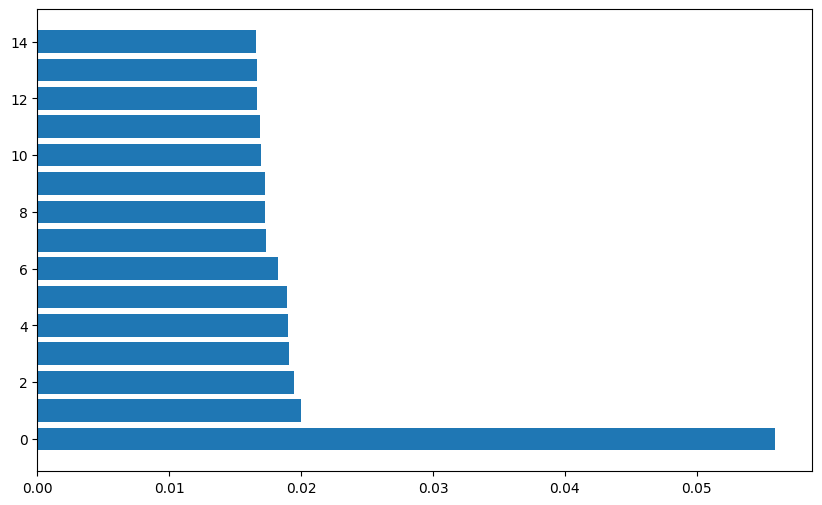

In [17]:
# Wyciągnięcie XGBoost z pipeline
xgb_model = model.named_steps['classifier']

# Ważność cech
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[-15:][::-1]  # Top 15

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel("Ważność cechy")
plt.title("Top 15 najważniejszych cech w XGBoost")
plt.gca().invert_yaxis()
plt.show()


In [16]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x=le.inverse_transform(y_train), order=le.classes_)
plt.title("Rozkład klas w zbiorze treningowym")
plt.xlabel("Klasa")
plt.ylabel("Liczba próbek")
plt.show()


ValueError: y contains previously unseen labels: ['D' 'H' 'NH']

<Figure size 600x400 with 0 Axes>